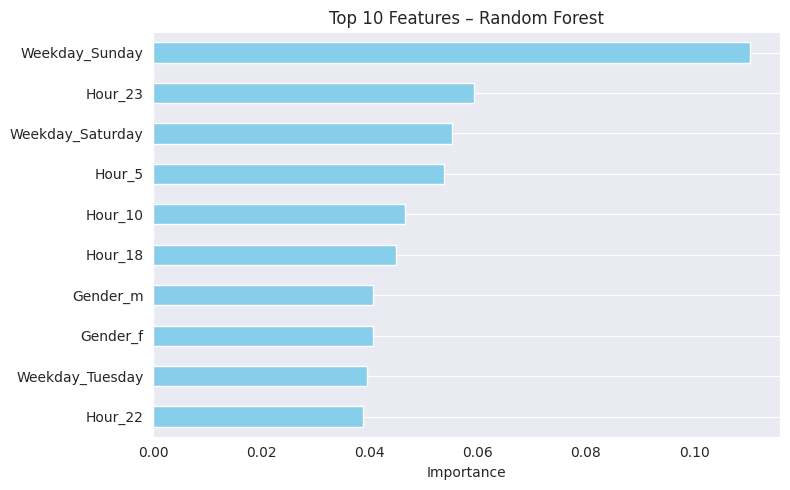

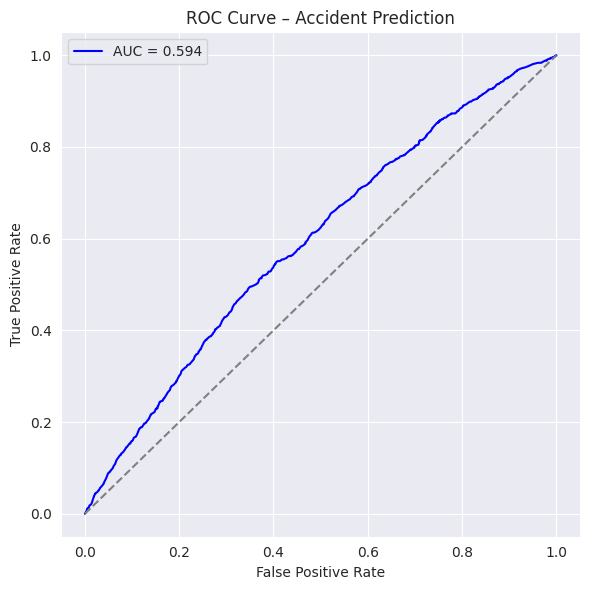

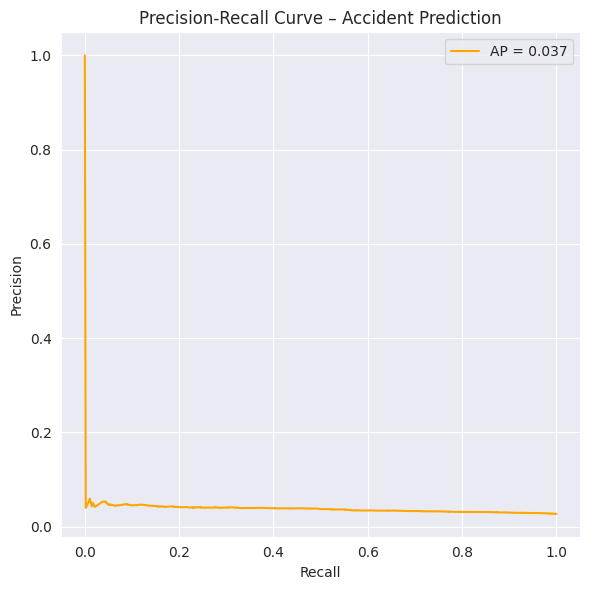

Confusion Matrix:
 [[38904     0]
 [ 1096     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     38904
           1       0.00      0.00      0.00      1096

    accuracy                           0.97     40000
   macro avg       0.49      0.50      0.49     40000
weighted avg       0.95      0.97      0.96     40000



In [ ]:
# ===============================
# 0️⃣ Import libraries
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_curve, roc_auc_score, 
    precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix
)

sns.set_style("darkgrid")

# ===============================
# 1️⃣ Load & Sample Data
# ===============================
df = pd.read_csv('/kaggle/input/traffic-violations/Traffic_Violations.csv', low_memory=False)
df = df.sample(200_000, random_state=42)

# ===============================
# 2️⃣ Clean Columns
# ===============================
# Dates & Hours
df['Date Of Stop'] = pd.to_datetime(df['Date Of Stop'], errors='coerce')
df['Hour'] = pd.to_datetime(df['Time Of Stop'], format='%H:%M:%S', errors='coerce').dt.hour
df['Weekday'] = df['Date Of Stop'].dt.day_name()

# Text columns
df['Gender'] = df['Gender'].astype(str).str.lower().fillna("unknown")
df['VehicleType'] = df['VehicleType'].astype(str).str.lower().fillna("unknown")

# Target column
df['Accident'] = df['Accident'].astype(str).str.lower().isin(['yes','true','1']).astype(int)

# Drop rows without Hour or Weekday
df = df.dropna(subset=['Hour','Weekday'])

# ===============================
# 3️⃣ Prepare ML Dataset
# ===============================
features = ['Hour', 'Weekday', 'Gender', 'VehicleType']
X = df[features].fillna("unknown")
y = df['Accident']

# One-Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# ===============================
# 4️⃣ Random Forest
# ===============================
rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=12, class_weight='balanced', random_state=42
)
rf_model.fit(X_train, y_train)

# Calibrated Probabilities
calibrated_rf = CalibratedClassifierCV(rf_model, method='sigmoid', cv=3)
calibrated_rf.fit(X_train, y_train)
y_prob_rf = calibrated_rf.predict_proba(X_test)[:,1]

# ===============================
# 5️⃣ Feature Importance
# ===============================
rf_feature_names = encoder.get_feature_names_out(features)
importance_df = pd.Series(rf_model.feature_importances_, index=rf_feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,5))
importance_df.head(10).plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 10 Features – Random Forest")
plt.xlabel("Importance")
plt.grid(axis='x')
plt.tight_layout()
plt.savefig("feature_importance_linkedin.png", dpi=300)
plt.show()

# ===============================
# 6️⃣ ROC Curve
# ===============================
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
auc_score = roc_auc_score(y_test, y_prob_rf)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", color='blue')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Accident Prediction")
plt.legend()
plt.tight_layout()
plt.savefig("roc_curve_linkedin.png", dpi=300)
plt.show()

# ===============================
# 7️⃣ Precision-Recall Curve
# ===============================
precision, recall, _ = precision_recall_curve(y_test, y_prob_rf)
ap = average_precision_score(y_test, y_prob_rf)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}", color='orange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Accident Prediction")
plt.legend()
plt.tight_layout()
plt.savefig("pr_curve_linkedin.png", dpi=300)
plt.show()

# ===============================
# 8️⃣ Classification Report
# ===============================
y_pred = (y_prob_rf >= 0.5).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

